In [64]:
import torch
from torch import nn
from transformers import XLNetTokenizer, XLNetForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import pandas as pd
from tqdm import tqdm

In [55]:
import numpy as np
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import get_linear_schedule_with_warmup

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
model_name = "xlnet-base-cased"

# Load tokenizer
tokenizer = XLNetTokenizer.from_pretrained(model_name)

In [14]:
df = pd.read_csv('cleaned_labeled_partitions.csv')

In [15]:
df['num_label'] = pd.factorize(df['label'])[0]
df = df.drop('label', axis=1)

In [16]:
df['num_label'].unique()

array([0, 1, 2, 3, 4])

In [22]:
class TextDataset(Dataset):
    def __init__(self, dataframe):
        self.texts = dataframe['text'].tolist()
        self.labels = dataframe['num_label'].tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=101,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [23]:
dataset = TextDataset(df)

In [44]:
dataset[0]

{'input_ids': tensor([ 5403, 14271,  8662,  1196,  2405,  3771,  2412,    89,    92,  4645,
            87,  1676,  1859,  2611,  5088, 10899,   309, 13967,  2138, 26432,
          6578,  1859, 12473,    17,    23,  1232,    98,   213,  4018,    17,
          4221,  2096,   390,  7120, 15399,   981,  2921,   218,  6565, 22933,
          4366,  7104, 18585,  2405,  3771,    17,    23,  8475,  3744, 19616,
           590,    17,  3848,   943,  6814,  2950, 13301,  2138,  1899,  9745,
         14271,   155,  5794,   527,    17,    23,  8475,  3744, 19616,   590,
            17,  3848,   943,  6814,  6627,  1427,    17, 27520,   697,  3963,
          3897,  3771,  1427,   800,  2036,  7104, 10899,    17,    23,   215,
            17,    23,   368,   213,    17,    23,   215,    17,    23,     4,
             3]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [59]:
def train_model(train_loader, model, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    
    for batch in train_loader:
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        total_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    
    return total_loss / len(train_loader)


In [60]:
# Evaluation function
def evaluate_model(test_loader, model, device):
    model.eval()
    predictions = []
    true_labels = []
    total_loss = 0
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            total_loss += loss.item()
            
            logits = outputs.logits
            batch_preds = torch.argmax(logits, dim=1).cpu().numpy()
            
            predictions.extend(batch_preds)
            true_labels.extend(labels.cpu().numpy())
    
    return {
        'loss': total_loss / len(test_loader),
        'accuracy': accuracy_score(true_labels, predictions),
        'f1': f1_score(true_labels, predictions, average='weighted'),
        'predictions': predictions,
        'true_labels': true_labels
    }

In [91]:
num_folds = 10
batch_size = 16

In [92]:
train_whole, test_whole = train_test_split(dataset, test_size=0.1)
all_indices = np.arange(len(train_whole))

In [93]:
len(train_whole)

900

In [88]:
epochs = 50

train1, test1 = train_test_split(train_whole, test_size=0.1)
all_indices = np.arange(len(train1))

train1_loader = DataLoader(train1, batch_size=batch_size, shuffle=True)
test1_loader = DataLoader(test1, batch_size=batch_size)

model_actual = XLNetForSequenceClassification.from_pretrained(
        model_name,
        num_labels=5
    ).to(device)

train_losses = []
eval_losses = []
eval_accuracies = []

optimizer = AdamW(model_actual.parameters(), lr=2e-5)
total_steps = len(train1_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
    
    # Training loop
for epoch in range(epochs):
    train_loss = train_model(train1_loader, model_actual, optimizer, scheduler, device)
    eval_results = evaluate_model(test1_loader, model_actual, device)
    
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {eval_results['loss']:.4f}")
    print(f"Val Accuracy: {eval_results['accuracy']:.4f}")
    print(f"Val F1: {eval_results['f1']:.4f}")
    print("-" * 10)

    train_losses.append(train_loss)
    eval_losses.append(eval_results['loss'])
    eval_accuracies.append(eval_results['accuracy'])

# # Print classification report for the fold
# print(f"\nClassification Report for Fold {fold + 1}:")
# print(classification_report(
#     eval_results['true_labels'],
#     eval_results['predictions']
# ))

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/50
Train Loss: 1.4023
Val Loss: 0.7455
Val Accuracy: 0.7778
Val F1: 0.7693
----------
Epoch 2/50
Train Loss: 0.4750
Val Loss: 0.3235
Val Accuracy: 0.8778
Val F1: 0.8780
----------
Epoch 3/50
Train Loss: 0.2598
Val Loss: 0.2808
Val Accuracy: 0.9111
Val F1: 0.9113
----------
Epoch 4/50
Train Loss: 0.1415
Val Loss: 0.3574
Val Accuracy: 0.9111
Val F1: 0.9109
----------
Epoch 5/50
Train Loss: 0.0739
Val Loss: 0.5433
Val Accuracy: 0.8889
Val F1: 0.8888
----------
Epoch 6/50
Train Loss: 0.0658
Val Loss: 0.4205
Val Accuracy: 0.9111
Val F1: 0.9092
----------
Epoch 7/50
Train Loss: 0.0288
Val Loss: 0.3988
Val Accuracy: 0.9333
Val F1: 0.9333
----------
Epoch 8/50
Train Loss: 0.0136
Val Loss: 0.5373
Val Accuracy: 0.9000
Val F1: 0.9016
----------
Epoch 9/50
Train Loss: 0.0174
Val Loss: 0.5638
Val Accuracy: 0.9111
Val F1: 0.9127
----------
Epoch 10/50
Train Loss: 0.0085
Val Loss: 0.4098
Val Accuracy: 0.9333
Val F1: 0.9332
----------
Epoch 11/50
Train Loss: 0.0137
Val Loss: 0.5029
Val Accurac

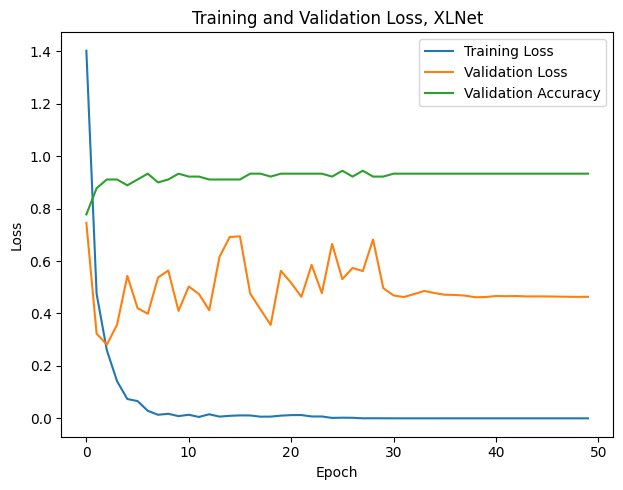

In [94]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(eval_losses, label='Validation Loss')
plt.plot(eval_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Loss, XLNet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.tight_layout()
plt.show()

In [95]:
print(classification_report(
    eval_results['true_labels'],
    eval_results['predictions']
))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      0.82      0.90        17
           2       0.76      1.00      0.86        16
           3       0.94      0.89      0.92        19
           4       1.00      0.93      0.97        15

    accuracy                           0.93        90
   macro avg       0.94      0.93      0.93        90
weighted avg       0.95      0.93      0.93        90



In [96]:
epochs = 35 
num_folds = 10

kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Main training loop with K-Fold CV
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(all_indices)):
    print(f"\n=== Fold {fold + 1}/{num_folds} ===")
    
    # Create train and validation datasets
    train_subset = Subset(train_whole, train_idx)
    val_subset = Subset(train_whole, val_idx)
    
    # Create data loaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size)
    
    # Initialize model for each fold
    model = XLNetForSequenceClassification.from_pretrained(
        model_name,
        num_labels=5
    ).to(device)
    
    # Optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=2e-5)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )
    
    # Training loop
    for epoch in range(epochs):
        train_loss = train_model(train_loader, model, optimizer, scheduler, device)
        eval_results = evaluate_model(val_loader, model, device)
        
        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {eval_results['loss']:.4f}")
        print(f"Val Accuracy: {eval_results['accuracy']:.4f}")
        print(f"Val F1: {eval_results['f1']:.4f}")
        print("-" * 50)
    
    # Store fold results
    fold_results.append(eval_results)
    
    # Print classification report for the fold
    print(f"\nClassification Report for Fold {fold + 1}:")
    print(classification_report(
        eval_results['true_labels'],
        eval_results['predictions']
    ))

# Print overall results
print("\n=== Final Results ===")
accuracies = [result['accuracy'] for result in fold_results]
f1_scores = [result['f1'] for result in fold_results]

print(f"Average Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Average F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print("\nDetailed Metrics per Fold:")
for i, result in enumerate(fold_results):
    print(f"Fold {i + 1}: Accuracy = {result['accuracy']:.4f}, F1 = {result['f1']:.4f}")


=== Fold 1/10 ===


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/35
Train Loss: 1.6311
Val Loss: 1.6032
Val Accuracy: 0.2444
Val F1: 0.0960
--------------------------------------------------
Epoch 2/35
Train Loss: 1.5324
Val Loss: 1.2894
Val Accuracy: 0.6000
Val F1: 0.5827
--------------------------------------------------
Epoch 3/35
Train Loss: 0.6728
Val Loss: 0.3654
Val Accuracy: 0.8556
Val F1: 0.8562
--------------------------------------------------
Epoch 4/35
Train Loss: 0.2848
Val Loss: 0.4236
Val Accuracy: 0.8889
Val F1: 0.8870
--------------------------------------------------
Epoch 5/35
Train Loss: 0.1626
Val Loss: 0.2990
Val Accuracy: 0.9333
Val F1: 0.9333
--------------------------------------------------
Epoch 6/35
Train Loss: 0.1186
Val Loss: 0.3980
Val Accuracy: 0.9222
Val F1: 0.9224
--------------------------------------------------
Epoch 7/35
Train Loss: 0.0418
Val Loss: 0.4920
Val Accuracy: 0.9222
Val F1: 0.9226
--------------------------------------------------
Epoch 8/35
Train Loss: 0.0688
Val Loss: 0.4579
Val Accuracy: 0

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/35
Train Loss: 1.5810
Val Loss: 1.4746
Val Accuracy: 0.3111
Val F1: 0.1778
--------------------------------------------------
Epoch 2/35
Train Loss: 0.9485
Val Loss: 0.5928
Val Accuracy: 0.8222
Val F1: 0.8201
--------------------------------------------------
Epoch 3/35
Train Loss: 0.3598
Val Loss: 0.5505
Val Accuracy: 0.8556
Val F1: 0.8513
--------------------------------------------------
Epoch 4/35
Train Loss: 0.2137
Val Loss: 0.4928
Val Accuracy: 0.8889
Val F1: 0.8857
--------------------------------------------------
Epoch 5/35
Train Loss: 0.1454
Val Loss: 0.5826
Val Accuracy: 0.8889
Val F1: 0.8872
--------------------------------------------------
Epoch 6/35
Train Loss: 0.0723
Val Loss: 0.6788
Val Accuracy: 0.9000
Val F1: 0.8964
--------------------------------------------------
Epoch 7/35
Train Loss: 0.0633
Val Loss: 0.6555
Val Accuracy: 0.9111
Val F1: 0.9099
--------------------------------------------------
Epoch 8/35
Train Loss: 0.0148
Val Loss: 0.7323
Val Accuracy: 0

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/35
Train Loss: 1.5092
Val Loss: 0.8964
Val Accuracy: 0.7000
Val F1: 0.6678
--------------------------------------------------
Epoch 2/35
Train Loss: 0.5615
Val Loss: 0.2718
Val Accuracy: 0.9222
Val F1: 0.9209
--------------------------------------------------
Epoch 3/35
Train Loss: 0.2640
Val Loss: 0.3612
Val Accuracy: 0.8444
Val F1: 0.8237
--------------------------------------------------
Epoch 4/35
Train Loss: 0.1738
Val Loss: 0.1159
Val Accuracy: 0.9778
Val F1: 0.9778
--------------------------------------------------
Epoch 5/35
Train Loss: 0.1023
Val Loss: 0.1693
Val Accuracy: 0.9444
Val F1: 0.9444
--------------------------------------------------
Epoch 6/35
Train Loss: 0.0432
Val Loss: 0.1952
Val Accuracy: 0.9556
Val F1: 0.9555
--------------------------------------------------
Epoch 7/35
Train Loss: 0.0480
Val Loss: 0.1559
Val Accuracy: 0.9556
Val F1: 0.9556
--------------------------------------------------
Epoch 8/35
Train Loss: 0.0169
Val Loss: 0.0598
Val Accuracy: 0

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/35
Train Loss: 1.2612
Val Loss: 0.5186
Val Accuracy: 0.8333
Val F1: 0.8340
--------------------------------------------------
Epoch 2/35
Train Loss: 0.4066
Val Loss: 0.2419
Val Accuracy: 0.9444
Val F1: 0.9444
--------------------------------------------------
Epoch 3/35
Train Loss: 0.1998
Val Loss: 0.2063
Val Accuracy: 0.9333
Val F1: 0.9314
--------------------------------------------------
Epoch 4/35
Train Loss: 0.1142
Val Loss: 0.5975
Val Accuracy: 0.8444
Val F1: 0.8472
--------------------------------------------------
Epoch 5/35
Train Loss: 0.0687
Val Loss: 0.4978
Val Accuracy: 0.8333
Val F1: 0.8362
--------------------------------------------------
Epoch 6/35
Train Loss: 0.0485
Val Loss: 0.5814
Val Accuracy: 0.9000
Val F1: 0.9007
--------------------------------------------------
Epoch 7/35
Train Loss: 0.0529
Val Loss: 0.5755
Val Accuracy: 0.8889
Val F1: 0.8878
--------------------------------------------------
Epoch 8/35
Train Loss: 0.0101
Val Loss: 0.6210
Val Accuracy: 0

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/35
Train Loss: 1.2672
Val Loss: 0.7318
Val Accuracy: 0.7222
Val F1: 0.6865
--------------------------------------------------
Epoch 2/35
Train Loss: 0.4145
Val Loss: 0.4755
Val Accuracy: 0.8333
Val F1: 0.8314
--------------------------------------------------
Epoch 3/35
Train Loss: 0.2240
Val Loss: 0.4318
Val Accuracy: 0.8667
Val F1: 0.8655
--------------------------------------------------
Epoch 4/35
Train Loss: 0.1139
Val Loss: 0.6405
Val Accuracy: 0.8667
Val F1: 0.8670
--------------------------------------------------
Epoch 5/35
Train Loss: 0.0881
Val Loss: 0.6957
Val Accuracy: 0.8667
Val F1: 0.8675
--------------------------------------------------
Epoch 6/35
Train Loss: 0.0368
Val Loss: 0.6491
Val Accuracy: 0.8667
Val F1: 0.8657
--------------------------------------------------
Epoch 7/35
Train Loss: 0.0199
Val Loss: 0.6847
Val Accuracy: 0.8778
Val F1: 0.8785
--------------------------------------------------
Epoch 8/35
Train Loss: 0.0271
Val Loss: 0.6780
Val Accuracy: 0

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/35
Train Loss: 1.4497
Val Loss: 0.6271
Val Accuracy: 0.8333
Val F1: 0.8314
--------------------------------------------------
Epoch 2/35
Train Loss: 0.5305
Val Loss: 0.2986
Val Accuracy: 0.9333
Val F1: 0.9330
--------------------------------------------------
Epoch 3/35
Train Loss: 0.2722
Val Loss: 0.4937
Val Accuracy: 0.8444
Val F1: 0.8455
--------------------------------------------------
Epoch 4/35
Train Loss: 0.1852
Val Loss: 0.2339
Val Accuracy: 0.8889
Val F1: 0.8867
--------------------------------------------------
Epoch 5/35
Train Loss: 0.0793
Val Loss: 0.2931
Val Accuracy: 0.9333
Val F1: 0.9338
--------------------------------------------------
Epoch 6/35
Train Loss: 0.0567
Val Loss: 0.3210
Val Accuracy: 0.9333
Val F1: 0.9335
--------------------------------------------------
Epoch 7/35
Train Loss: 0.0222
Val Loss: 0.3535
Val Accuracy: 0.9556
Val F1: 0.9557
--------------------------------------------------
Epoch 8/35
Train Loss: 0.0053
Val Loss: 0.3816
Val Accuracy: 0

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/35
Train Loss: 1.3972
Val Loss: 0.6948
Val Accuracy: 0.7889
Val F1: 0.7692
--------------------------------------------------
Epoch 2/35
Train Loss: 0.4782
Val Loss: 0.3757
Val Accuracy: 0.8667
Val F1: 0.8692
--------------------------------------------------
Epoch 3/35
Train Loss: 0.3026
Val Loss: 0.2270
Val Accuracy: 0.9000
Val F1: 0.9031
--------------------------------------------------
Epoch 4/35
Train Loss: 0.2035
Val Loss: 0.4196
Val Accuracy: 0.8667
Val F1: 0.8659
--------------------------------------------------
Epoch 5/35
Train Loss: 0.1227
Val Loss: 0.3303
Val Accuracy: 0.9000
Val F1: 0.9042
--------------------------------------------------
Epoch 6/35
Train Loss: 0.0745
Val Loss: 0.1156
Val Accuracy: 0.9778
Val F1: 0.9782
--------------------------------------------------
Epoch 7/35
Train Loss: 0.0570
Val Loss: 0.1090
Val Accuracy: 0.9778
Val F1: 0.9782
--------------------------------------------------
Epoch 8/35
Train Loss: 0.0228
Val Loss: 0.1118
Val Accuracy: 0

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/35
Train Loss: 1.2226
Val Loss: 0.5862
Val Accuracy: 0.8000
Val F1: 0.7847
--------------------------------------------------
Epoch 2/35
Train Loss: 0.3847
Val Loss: 0.2738
Val Accuracy: 0.8778
Val F1: 0.8738
--------------------------------------------------
Epoch 3/35
Train Loss: 0.2161
Val Loss: 0.1618
Val Accuracy: 0.9444
Val F1: 0.9442
--------------------------------------------------
Epoch 4/35
Train Loss: 0.1178
Val Loss: 0.2745
Val Accuracy: 0.9222
Val F1: 0.9233
--------------------------------------------------
Epoch 5/35
Train Loss: 0.0649
Val Loss: 0.1759
Val Accuracy: 0.9333
Val F1: 0.9285
--------------------------------------------------
Epoch 6/35
Train Loss: 0.0365
Val Loss: 0.1366
Val Accuracy: 0.9667
Val F1: 0.9659
--------------------------------------------------
Epoch 7/35
Train Loss: 0.0300
Val Loss: 0.2881
Val Accuracy: 0.9444
Val F1: 0.9411
--------------------------------------------------
Epoch 8/35
Train Loss: 0.0175
Val Loss: 0.2253
Val Accuracy: 0

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/35
Train Loss: 1.3556
Val Loss: 0.7438
Val Accuracy: 0.6889
Val F1: 0.6797
--------------------------------------------------
Epoch 2/35
Train Loss: 0.5212
Val Loss: 0.4626
Val Accuracy: 0.8333
Val F1: 0.8320
--------------------------------------------------
Epoch 3/35
Train Loss: 0.2687
Val Loss: 0.4557
Val Accuracy: 0.8333
Val F1: 0.8333
--------------------------------------------------
Epoch 4/35
Train Loss: 0.1577
Val Loss: 0.4479
Val Accuracy: 0.8667
Val F1: 0.8664
--------------------------------------------------
Epoch 5/35
Train Loss: 0.0777
Val Loss: 0.5386
Val Accuracy: 0.9000
Val F1: 0.8996
--------------------------------------------------
Epoch 6/35
Train Loss: 0.0515
Val Loss: 0.6918
Val Accuracy: 0.8667
Val F1: 0.8660
--------------------------------------------------
Epoch 7/35
Train Loss: 0.0387
Val Loss: 0.6267
Val Accuracy: 0.8778
Val F1: 0.8801
--------------------------------------------------
Epoch 8/35
Train Loss: 0.0239
Val Loss: 0.5402
Val Accuracy: 0

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/35
Train Loss: 1.3343
Val Loss: 0.5942
Val Accuracy: 0.8111
Val F1: 0.8088
--------------------------------------------------
Epoch 2/35
Train Loss: 0.4323
Val Loss: 0.3860
Val Accuracy: 0.8778
Val F1: 0.8771
--------------------------------------------------
Epoch 3/35
Train Loss: 0.2430
Val Loss: 0.3504
Val Accuracy: 0.9000
Val F1: 0.8961
--------------------------------------------------
Epoch 4/35
Train Loss: 0.1390
Val Loss: 0.1922
Val Accuracy: 0.9667
Val F1: 0.9670
--------------------------------------------------
Epoch 5/35
Train Loss: 0.0962
Val Loss: 0.3942
Val Accuracy: 0.9000
Val F1: 0.8988
--------------------------------------------------
Epoch 6/35
Train Loss: 0.0308
Val Loss: 0.3057
Val Accuracy: 0.9444
Val F1: 0.9457
--------------------------------------------------
Epoch 7/35
Train Loss: 0.0256
Val Loss: 0.2604
Val Accuracy: 0.9556
Val F1: 0.9556
--------------------------------------------------
Epoch 8/35
Train Loss: 0.0182
Val Loss: 0.4592
Val Accuracy: 0

In [99]:
model_actual.save_pretrained("./xlnet_classifier")
tokenizer.save_pretrained("./xlnet_classifier")

('./xlnet_classifier/tokenizer_config.json',
 './xlnet_classifier/special_tokens_map.json',
 './xlnet_classifier/spiece.model',
 './xlnet_classifier/added_tokens.json')